In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import h5py

def load_data(src):
    with h5py.File(src, "r") as f:
        keys = list(f.keys())
        raw = f[keys[0]][:]  

    # Convert to text
    text = raw.tobytes().decode("utf-8")

    # Load as json
    data_json = json.loads(text)

    df = pd.DataFrame(data_json)

    return df

def calculate_metrics(df):

    # Convert values to float
    df["time"] = df["time"].astype(float)
    df["voltage"] = df["voltage"].astype(float)
    df["current"] = df["current"].astype(float)

    # Identify changes in status to segment the data
    df.loc[:, "state_change"] = (df["State"] != df["State"].shift()).cumsum()

    # Group by status change segments
    grouped = df.groupby("state_change")

    results = []

    for _, g in grouped:
        subset = g.iloc[1:-1]

        if subset.empty or subset["State"].isna().all():
            continue

        status = subset["State"].iloc[0]
        start_time = subset["time"].iloc[0]
        end_time = subset["time"].iloc[-1]
        duration = end_time - start_time

        avg_current = subset["current"].mean()
        std_current = subset["current"].std()

        avg_tension = subset["voltage"].mean()
        std_tension = subset["voltage"].std()

        results.append({
            "status": status,
            "start_time": start_time,
            "end_time": end_time,
            "duration": duration,
            "avg_current": avg_current,
            "std_current": std_current,
            "avg_tension": avg_tension,
            "std_tension": std_tension
        })

    results = pd.DataFrame(results)

    return results

In [ ]:
import os

src = "../../../../../../media/mods-pred/Datasets/Data_uconn_h5"
checkups_paths = []

for cell in sorted(os.listdir(src)):
    cell_path = os.path.join(src, cell)
    for file in sorted(os.listdir(cell_path)):
        if "CHECKUP" in file:
            checkups_paths.append(os.path.join(cell_path, file))

all_cycles = []

for checkup in checkups_paths:
    df = load_data(checkup)
    results = calculate_metrics(df)

    status_counts = {}

    features = {}

    for i, row in results.iterrows():
        current_status = row['status']
        
        status_counts[current_status] = status_counts.get(current_status, 0) + 1
        
        # Ex: "Rest1", "CC Chg1", "Rest2"
        period = f"{current_status}{status_counts[current_status]}"
        
        features[f"{period}_avg_current"] = row["avg_current"]
        features[f"{period}_std_current"] = row["std_current"]
        features[f"{period}_avg_tension"] = row["avg_tension"]
        features[f"{period}_std_tension"] = row["std_tension"]
        features[f"{period}_duration"] = row["duration"]

    features["SoH"] = max(df["capacity"].astype(float)) * 100 / 1.2
    features["cell_id"] = os.path.basename(os.path.dirname(checkup))

    all_cycles.append(features)

dataset = pd.DataFrame(all_cycles).fillna(0)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

cells = dataset["cell_id"].unique()
train_cells, test_cells = train_test_split(cells, test_size=0.2, random_state=42)

train_df = dataset[dataset["cell_id"].isin(train_cells)]
test_df = dataset[dataset["cell_id"].isin(test_cells)]

X_train = train_df.drop(columns=["SoH", "cell_id"])
y_train = train_df["SoH"]
X_test = test_df.drop(columns=["SoH", "cell_id"])
y_test = test_df["SoH"]

# ------------------------
# Regressão Linear
# ------------------------
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
y_pred_lin = lin_model.predict(X_test)

print("=== Regressão Linear ===")
print("R² teste:", r2_score(y_test, y_pred_lin))
print("MAE:", mean_absolute_error(y_test, y_pred_lin))
coef = pd.Series(lin_model.coef_, index=X_train.columns)
print("Features mais importantes (RL):")
print(coef.sort_values(key=abs, ascending=False))

# ------------------------
# Random Forest
# ------------------------
rf_model = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("\n=== Random Forest ===")
print("R² teste:", r2_score(y_test, y_pred_rf))
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
print("Features mais importantes (RF):")
print(importances.sort_values(ascending=False))

=== Regressão Linear ===
R² teste: -1831959.3996397955
MAE: 593.7915226080364
Features mais importantes (RL):
CC Chg8_avg_current     -37628.619136
CC Chg14_avg_current     26666.247487
CC DChg32_std_current    21674.192737
CC DChg38_std_current   -14175.845572
CC Chg14_std_current    -13981.474484
                             ...     
Rest4_avg_current            0.000000
Rest46_avg_current           0.000000
Rest46_std_current           0.000000
Rest45_avg_current           0.000000
Rest45_std_current           0.000000
Length: 775, dtype: float64

=== Random Forest ===
R² teste: 0.9394704801327631
MAE: 0.5201481871493359
Features mais importantes (RF):
CC DChg22_duration      0.376715
CC DChg1_avg_tension    0.248910
CC DChg1_duration       0.123679
CC Chg24_std_tension    0.039380
CC Chg24_duration       0.035271
                          ...   
Rest45_avg_current      0.000000
Rest45_std_current      0.000000
Rest45_avg_tension      0.000000
Rest45_std_tension      0.000000
Rest45

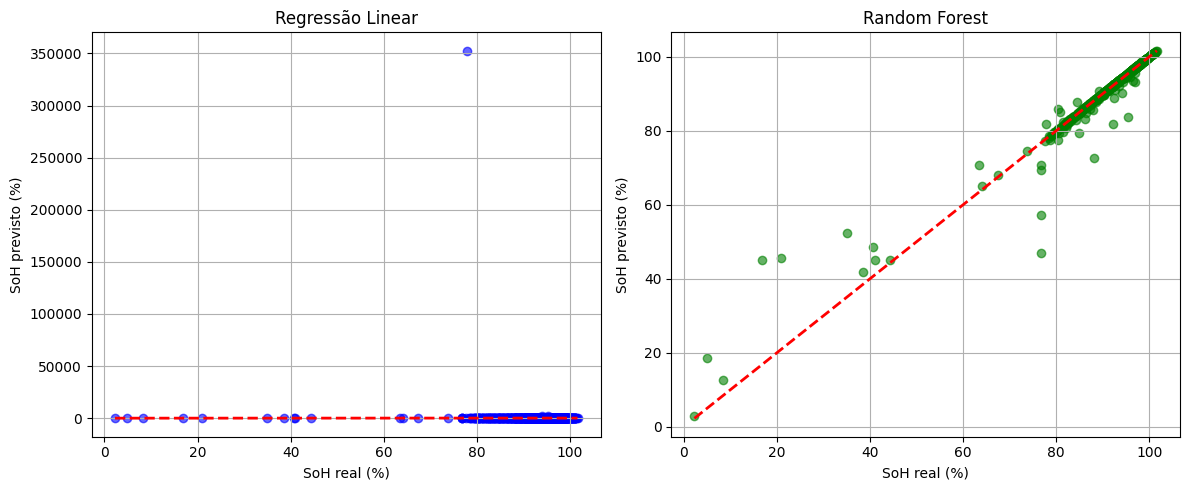

In [ ]:
plt.figure(figsize=(12,5))

# RL
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_lin, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("SoH real (%)")
plt.ylabel("SoH previsto (%)")
plt.title("Regressão Linear")
plt.grid(True)

# RF
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_rf, color='green', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("SoH real (%)")
plt.ylabel("SoH previsto (%)")
plt.title("Random Forest")
plt.grid(True)

plt.tight_layout()
plt.show()


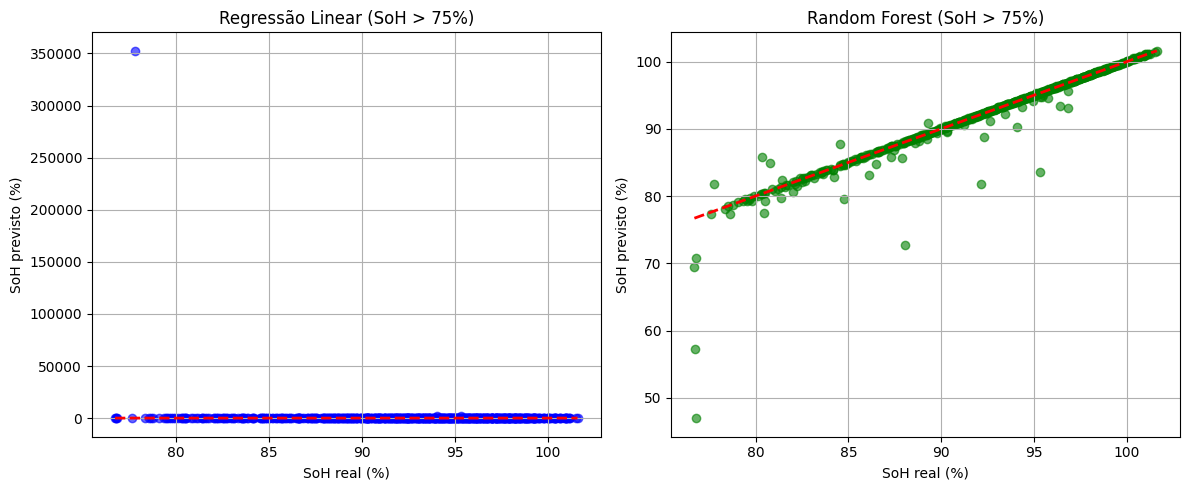

In [ ]:
mask = y_test > 75
y_test_filtered = y_test[mask]
y_pred_lin_filtered = y_pred_lin[mask]
y_pred_rf_filtered = y_pred_rf[mask]

plt.figure(figsize=(12,5))

# RL
plt.subplot(1, 2, 1)
plt.scatter(y_test_filtered, y_pred_lin_filtered, color='blue', alpha=0.6)
plt.plot([y_test_filtered.min(), y_test_filtered.max()],
         [y_test_filtered.min(), y_test_filtered.max()], 'r--', lw=2)
plt.xlabel("SoH real (%)")
plt.ylabel("SoH previsto (%)")
plt.title("Regressão Linear (SoH > 75%)")
plt.grid(True)

# RF
plt.subplot(1, 2, 2)
plt.scatter(y_test_filtered, y_pred_rf_filtered, color='green', alpha=0.6)
plt.plot([y_test_filtered.min(), y_test_filtered.max()],
         [y_test_filtered.min(), y_test_filtered.max()], 'r--', lw=2)
plt.xlabel("SoH real (%)")
plt.ylabel("SoH previsto (%)")
plt.title("Random Forest (SoH > 75%)")
plt.grid(True)

plt.tight_layout()
plt.show()